# Matlab plots

In [1]:
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, isdir, join, splitext
import pandas as pd
import scipy.io
from scipy.signal import savgol_filter
from scipy import stats
import seaborn as sns
import sys
from config import *

In [2]:
def is_point_within_radius(point, target, radius):
    dist2 = (target[0] - point[0])**2 + (target[1] - point[1])**2
    if dist2 <= radius**2:
        return True
    return False

def grid_points_within_radius(center, radius, grid_steps):
    support = np.linspace(1/(grid_steps+1), 1 - 1/(grid_steps+1), grid_steps)
    points = []

    # The rows count down since the origin is now in the bottom left
    # instead of the top left
    for c in range(grid_steps):
        for r in range(grid_steps):
            dist2 = (center[0] - support[c])**2 + (center[1] - support[-r-1])**2
            if dist2 < radius**2:
                points.append((c, grid_steps-r-1))
    return [grid_steps*c + r for (c, r) in points]

# GENERATE SUCCESS PROBABILITY TABLE from dataframe
def highlight_top_k(s, k=1, cmap=[("black", "[HTML]{EEEEEE}")]):
    unsortedvals = [v for v in s.values if not np.isnan(v)]
    topk = sorted(unsortedvals, reverse=True)[:k]
    topk_vals = sorted(list(set(topk)), reverse=True)

    props = s.shape[0] * ['']

    for top_idx in range(len(topk_vals)):
        val = topk_vals[top_idx]
        text_color = cmap[top_idx][0]
        bg_color = cmap[top_idx][1]
        for c_idx in range(len(s.values)):
            if np.allclose(s.values[c_idx], val, atol=1e-3):
                props[c_idx] = f'color:{{{text_color}}}; cellcolor:{bg_color}; bfseries:'
    return np.array(props, dtype=object)


def relabel_data(val):
    if val > 0.999 and val < 1:
        return "$>$0.999"
    return format(round(val, 3), ".3f")


def relabel_index_headers(val):
    return val

In [3]:
global_min_locs = {
    "ackley": (0.5000,    0.5000),
    "ackley2": (0.5000, 0.5000),
    "alpine1": (0.5000,    0.5000),
    "alpine2": (0.7917,    0.7917),
    "bohachevsky2": (0.5000,    0.5000),
    "camel3": (0.5000,    0.5000),
    "csendes": (0.5000,    0.5000),
    "defl_corr_spring": (0.5000,    0.5000),
    "dropwave": (0.5000,    0.5000),
    "easom": (0.5000,    0.5000),
    "griewank": (0.5000,    0.5000),
    "holder": (0.8055,    0.9665),
    "hosaki": (0.8000,    0.4000),
    "levy": (0.5500,    0.5500),
    "levy13": (0.5500,    0.5500),
    "michalewicz": (0.7003,    0.4997),
    "rastrigin": (0.5000,    0.5000),
    "rosenbrock": (0.8333,    0.8333),
    "shubert": (0.3214,    0.7713),
    "styblinski_tang": (0.2097,    0.2097),
    "sumofsquares": (0.5000, 0.5000),
    "xinsheyang3": (0.5000, 0.5000)
}


# Sorted by QHD success prob in each category
features = {
    "Ridges and Valleys": [
        "dropwave",
        "holder",
        "ackley2",
        "levy13",
        "levy",
        
    ],
    "Basins": [
        "defl_corr_spring",
        "rosenbrock",
        "csendes",
        "camel3",
        "bohachevsky2",
    ],
    "Flat": [
        "xinsheyang3",
        "easom",
        "michalewicz",
    ],
    "Studded": [
        "griewank",
        "alpine1",
        "ackley",
        "rastrigin",
    ],
    "Simple": [
        "styblinski_tang",
        "alpine2",
        "shubert",
        "hosaki",
        "sumofsquares",    
    ]
}

fname_to_label = {
    "dropwave": "Drop-Wave",
    "levy": "Levy",
    "levy13": "Levy 13",
    "holder": "Holder Table",
    "ackley2": "Ackley 2",
    "bohachevsky2": "Bohachevsky 2",
    "rosenbrock": "Rosenbrock",
    "camel3": "Camel 3",
    "csendes": "Csendes",
    "defl_corr_spring": "Defl. Corr. Spring",
    "michalewicz": "Michalewicz",
    "easom": "Easom",
    "xinsheyang3": "Xin-She Yang 3",
    "alpine1": "Alpine 1",
    "griewank": "Griewank",
    "ackley": "Ackley",
    "rastrigin": "Rastrigin",
    "alpine2": "Alpine 2",
    "hosaki": "Hosaki",
    "shubert": "Shubert",
    "styblinski_tang": "Styblinski-Tang",
    "sumofsquares": "Sum of Squares"
}


# PLOT by methods across instances separated by instance type
which_to_plot = [ "KFAD", "LDHD", "SGD","NAGD"]

MARKER_SIZE = 5

CATTITLE_SIZE = 10
YLABEL_SIZE = 8
YTICKLABEL_SIZE = 8
XTICKLABEL_SIZE = 8
LEGEND_SIZE = 8

cmap = sns.color_palette("colorblind")
# cmap = cmap[:5] + cmap[8:]
cmap = cmap[:5] + cmap[6:]

In [4]:
dirs = list(global_min_locs.keys())
print(dirs)

['ackley', 'ackley2', 'alpine1', 'alpine2', 'bohachevsky2', 'camel3', 'csendes', 'defl_corr_spring', 'dropwave', 'easom', 'griewank', 'holder', 'hosaki', 'levy', 'levy13', 'michalewicz', 'rastrigin', 'rosenbrock', 'shubert', 'styblinski_tang', 'sumofsquares', 'xinsheyang3']


In [5]:
timesteps = [-3,-2,-1,0]
gammas = [-2,-1,0,1]

NUM_SHOTS = 1000

radius = 0.1
steps = 256
adb_steps = 64

for timestep in timesteps:
    for gamma in gammas:
        DATA_DIR_2D = f"/Users/analiacabello/Desktop/Y5/DISS/2D_matlab_experiments/timestep_{timestep}_gamma_{gamma}"
        # LOAD success prob data
        data = {
            "SGD": {},
            "LDHD": {},
            "KFAD": {},
            "NAGD": {},
            "QHD": {}
        }
        
        prob_data = {
            "SGD": [],
            "LDHD": [],
            "KFAD": [],
            "NAGD": [],
            "QHD": []
        }

        for d in dirs:
            if not isdir(join(DATA_DIR_2D, d)):
                print(f"The data path for function {d} is not found.")
            else:
                print(d)
                scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_SGD.mat"), mdict=data["SGD"])
        
                scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_LDHD.mat"), mdict=data["LDHD"])
                
                scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_KFAD.mat"), mdict=data["KFAD"])
                
                scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_NAGD.mat"), mdict=data["NAGD"])
                
        ####### # SGD
                counter = 0
                for i in range(NUM_SHOTS):
                    last_idx = data["SGD"]["ngd_last_frame"][i] - 1
                    point = data["SGD"]["ngd_positions"][i, last_idx, :][0]
        
                    if is_point_within_radius(point, global_min_locs[d], radius):
                        counter += 1
        
                prob_data["SGD"].append(counter / NUM_SHOTS)
        
        ####### # LDHD
                counter = 0
                for i in range(NUM_SHOTS):
                    point = data["LDHD"]["ldhd_positions"][i][-1]
        
                    if is_point_within_radius(point, global_min_locs[d], radius):
                        counter += 1
        
                prob_data["LDHD"].append(counter / NUM_SHOTS)
                
        ####### # KFAD
                counter = 0
                for i in range(NUM_SHOTS):
                    point = data["KFAD"]["kfad_positions"][i][-1]
        
                    if is_point_within_radius(point, global_min_locs[d], radius):
                        counter += 1
        
                prob_data["KFAD"].append(counter / NUM_SHOTS)
                
        ####### # NAGD
                counter = 0
                for i in range(NUM_SHOTS):
                    point = data["NAGD"]["nesterov_positions"][i][-1]
        
                    if is_point_within_radius(point, global_min_locs[d], radius):
                        counter += 1
        
                prob_data["NAGD"].append(counter / NUM_SHOTS)
        # STORE data in pd dataframe
        pd.set_option("display.precision", 3)
        
        prob_df = pd.DataFrame({
            "SGD": prob_data["SGD"],
            "LDHD": prob_data["LDHD"],
            "KFAD": prob_data["KFAD"],
            "NAGD": prob_data["NAGD"]},
            index=dirs)
        
        colored_table = prob_df.style.apply(highlight_top_k, axis=1).export()
        f, ax = plt.subplots(1, 5, figsize=(150/15, 4), dpi=300)
        f.suptitle(f"Timestep magnitude: {timestep}. Gamma magnitude: {gamma}.")
        plt.subplots_adjust(left=0.0, right=1)
        
        for method_idx in range(len(which_to_plot)):
            method = which_to_plot[method_idx]
            ax[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
            ax[0].set_ylabel("Success Probability", size=YLABEL_SIZE)
            for category_idx in range(len(list(features.keys()))):
                category = list(features.keys())[category_idx]
                X = list(range(len(features[category])))
                Y = [prob_df[method][dirs.index(fn)] for fn in features[category]]
        
                # Only connect QHD markers
                linestyle = ""
                if method == "KFAD":
                    linestyle = "-"
        
                ax[category_idx].plot(X, Y,
                    color=cmap[method_idx],
                    marker="o",
                    markersize=MARKER_SIZE,
                    linestyle=linestyle,
                    label=method
                )
        
                if category_idx > 0:
                    ax[category_idx].set_yticklabels([])
        
                ax[category_idx].set_title(category, fontsize=CATTITLE_SIZE)
                ax[category_idx].set_ylim([-0.05,1.05])
                ax[category_idx].set_xticks(list(range(len(X))))
                xlabels = [fname_to_label[fn] for fn in features[category]]
                ax[category_idx].set_xticklabels(xlabels, rotation=60,)
                ax[category_idx].tick_params(axis='x', which='major', labelsize=XTICKLABEL_SIZE)
        
        
        # plt.suptitle("Success Probability Across Instance Categories")
        ax[0].tick_params(axis='y', which='major', labelsize=YTICKLABEL_SIZE)
        plt.legend(bbox_to_anchor=(1, 1), prop={'size': LEGEND_SIZE})
        
        plt.savefig(f"./timestep_{timestep}_gamma_{gamma}/figures/SuccessProb2D.png", bbox_inches='tight', dpi=300)
        #plt.savefig(f"./timestep_{timestep}_gamma_{gamma}/figures/SuccessProb2D.svg", bbox_inches='tight')
        plt.show()

The data path for function ackley is not found.
The data path for function ackley2 is not found.
The data path for function alpine1 is not found.
The data path for function alpine2 is not found.
The data path for function bohachevsky2 is not found.
The data path for function camel3 is not found.
The data path for function csendes is not found.
The data path for function defl_corr_spring is not found.
The data path for function dropwave is not found.
The data path for function easom is not found.
The data path for function griewank is not found.
The data path for function holder is not found.
The data path for function hosaki is not found.
The data path for function levy is not found.
The data path for function levy13 is not found.
The data path for function michalewicz is not found.
The data path for function rastrigin is not found.
The data path for function rosenbrock is not found.
The data path for function shubert is not found.
The data path for function styblinski_tang is not foun

ValueError: Length of values (0) does not match length of index (22)

ackley
ackley2
alpine1
alpine2
bohachevsky2
camel3
csendes
defl_corr_spring
dropwave
easom
griewank
holder
hosaki
levy
levy13
michalewicz
rastrigin
rosenbrock
shubert
styblinski_tang
sumofsquares
xinsheyang3


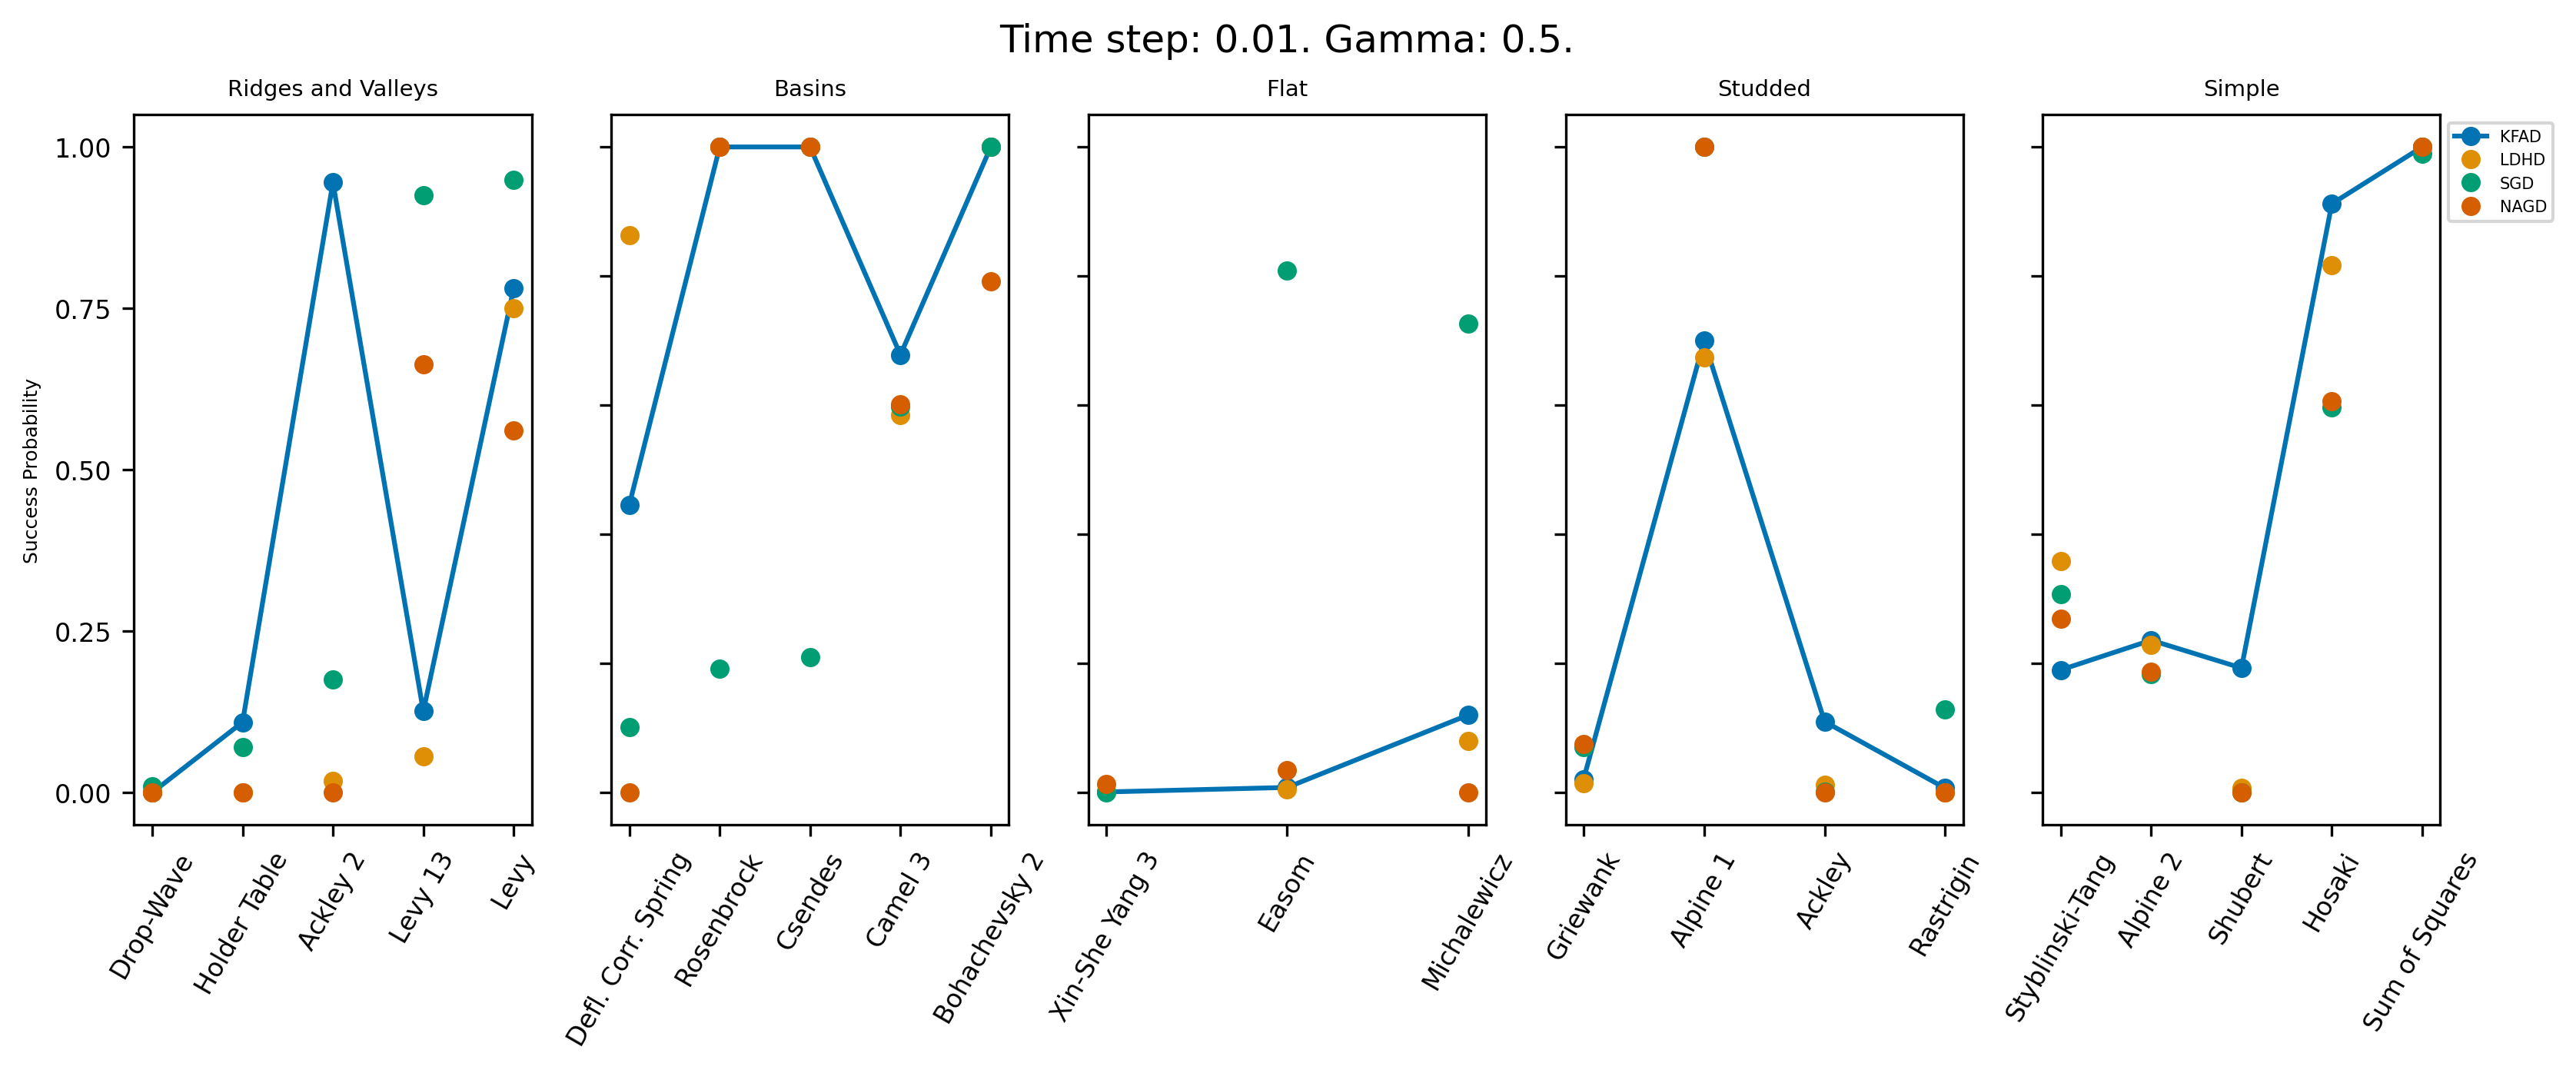

In [8]:
NUM_SHOTS = 1000

radius = 0.1
steps = 256
adb_steps = 64


DATA_DIR_2D = "/Users/analiacabello/Desktop/Y5/DISS/2D_matlab_experiments"
sys.path.append(os.path.abspath('../../'))


# LOAD success prob data
data = {
    "SGD": {},
    "LDHD": {},
    "KFAD": {}
}

prob_data = {
    "SGD": [],
    "LDHD": [],
    "KFAD": []
}


NUM_SHOTS = 1000

radius = 0.1
steps = 256
adb_steps = 64

for d in dirs:
    if not isdir(join(DATA_DIR_2D, d)):
        print(f"The data path for function {d} is not found.")
    else:
        print(d)
        scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_SGD.mat"), mdict=data["SGD"])

        scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_LDHD.mat"), mdict=data["LDHD"])
        
        scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_KFAD.mat"), mdict=data["KFAD"])
        

        #adb_filename = f"{d}_QAA128_T10.mat"
        #adb_f = h5py.File(join(DATA_DIR_2D, d, adb_filename), 'r')
        #for k, v in adb_f.items():
        #    data["QAA"][k] = np.array(adb_f.get(k))

        #qhd_wfn_dir = f"{d}_QHD256_WFN"
        #data["QHD"]["wfn"] = np.load(os.path.join(DATA_DIR_2D, d, qhd_wfn_dir, "psi_100e-01.npy"))


####### # SGD
        counter = 0
        for i in range(NUM_SHOTS):
            last_idx = data["SGD"]["ngd_last_frame"][i] - 1
            point = data["SGD"]["ngd_positions"][i, last_idx, :][0]

            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1

        prob_data["SGD"].append(counter / NUM_SHOTS)

####### # LDHD
        counter = 0
        for i in range(NUM_SHOTS):
            point = data["LDHD"]["ldhd_positions"][i][-1]

            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1

        prob_data["LDHD"].append(counter / NUM_SHOTS)
        
####### # KFAD
        counter = 0
        for i in range(NUM_SHOTS):
            point = data["KFAD"]["kfad_positions"][i][-1]

            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1

        prob_data["KFAD"].append(counter / NUM_SHOTS)
        


####### # QUANTUM ADIABATIC
#        x_adb_data = data["QAA"]["snapshot_times"][0]
#        adb_wfn = data["QAA"]["wfn"].view(np.complex128)
#        adb_num_frames = len(x_adb_data)
#        adb_nbhd_prob = np.empty(adb_num_frames)
#        adb_nbhd_idcs = grid_points_within_radius(global_min_locs[d], radius, adb_steps)
#        adb_frame = adb_wfn[:,-1]
#        adb_nbhd_amps = adb_frame[adb_nbhd_idcs]
#        adb_prob = np.sum((adb_nbhd_amps * np.conj(adb_nbhd_amps)).real)
#        prob_data["QAA"].append(adb_prob)

####### # QUANTUM HAMILTONIAN DESCENT
#        nbhd_idcs = grid_points_within_radius(global_min_locs[d], radius, steps)
 #       nbhd_locs = np.zeros((steps * steps,1))
 #       nbhd_locs[nbhd_idcs] = 1
 #       nbhd_locs = np.reshape(nbhd_locs, (steps,steps), order='F')

 #       psi = data["QHD"]["wfn"]
 #       qhd_prob = (nbhd_locs * ((psi * psi.conj()).real)).sum()
  #      prob_data["QHD"].append(qhd_prob)


# STORE data in pd dataframe
pd.set_option("display.precision", 3)

prob_df = pd.DataFrame({
    "SGD": prob_data["SGD"],
    "LDHD": prob_data["LDHD"],
    "KFAD": prob_data["KFAD"],
    index=dirs)


# GENERATE SUCCESS PROBABILITY TABLE from dataframe
def highlight_top_k(s, k=1, cmap=[("black", "[HTML]{EEEEEE}")]):
    unsortedvals = [v for v in s.values if not np.isnan(v)]
    topk = sorted(unsortedvals, reverse=True)[:k]
    topk_vals = sorted(list(set(topk)), reverse=True)

    props = s.shape[0] * ['']

    for top_idx in range(len(topk_vals)):
        val = topk_vals[top_idx]
        text_color = cmap[top_idx][0]
        bg_color = cmap[top_idx][1]
        for c_idx in range(len(s.values)):
            if np.allclose(s.values[c_idx], val, atol=1e-3):
                props[c_idx] = f'color:{{{text_color}}}; cellcolor:{bg_color}; bfseries:'
    return np.array(props, dtype=object)


def relabel_data(val):
    if val > 0.999 and val < 1:
        return "$>$0.999"
    return format(round(val, 3), ".3f")


def relabel_index_headers(val):
    return val


colored_table = prob_df.style.apply(highlight_top_k, axis=1).export()

# Dump the table to the console
#print(prob_df.rename(lambda idx: idx.replace('_',' ')).style.format(relabel_data).use(colored_table).to_latex(column_format="l|cccc"))
# print(prob_df.rename(lambda idx: idx.replace('_',' ')).to_markdown(tablefmt="grid"))


# Sorted by QHD success prob in each category
features = {
    "Ridges and Valleys": [
        "dropwave",
        "holder",
        "ackley2",
        "levy13",
        "levy",
        
    ],
    "Basins": [
        "defl_corr_spring",
        "rosenbrock",
        "csendes",
        "camel3",
        "bohachevsky2",
    ],
    "Flat": [
        "xinsheyang3",
        "easom",
        "michalewicz",
    ],
    "Studded": [
        "griewank",
        "alpine1",
        "ackley",
        "rastrigin",
    ],
    "Simple": [
        "styblinski_tang",
        "alpine2",
        "shubert",
        "hosaki",
        "sumofsquares",    
    ]
}

fname_to_label = {
    "dropwave": "Drop-Wave",
    "levy": "Levy",
    "levy13": "Levy 13",
    "holder": "Holder Table",
    "ackley2": "Ackley 2",
    "bohachevsky2": "Bohachevsky 2",
    "rosenbrock": "Rosenbrock",
    "camel3": "Camel 3",
    "csendes": "Csendes",
    "defl_corr_spring": "Defl. Corr. Spring",
    "michalewicz": "Michalewicz",
    "easom": "Easom",
    "xinsheyang3": "Xin-She Yang 3",
    "alpine1": "Alpine 1",
    "griewank": "Griewank",
    "ackley": "Ackley",
    "rastrigin": "Rastrigin",
    "alpine2": "Alpine 2",
    "hosaki": "Hosaki",
    "shubert": "Shubert",
    "styblinski_tang": "Styblinski-Tang",
    "sumofsquares": "Sum of Squares"
}


# PLOT by methods across instances separated by instance type
which_to_plot = [ "KFAD", "LDHD", "SGD"]

MARKER_SIZE = 5

CATTITLE_SIZE = 7
YLABEL_SIZE = 6
YTICKLABEL_SIZE = 8
XTICKLABEL_SIZE = 8
LEGEND_SIZE = 5

cmap = sns.color_palette("colorblind")
# cmap = cmap[:5] + cmap[8:]
cmap = cmap[:5] + cmap[6:]

f, ax = plt.subplots(1, 5, figsize=(150/15, 4), dpi=300)
f.suptitle("Time step: 0.01. Gamma: 0.5.")
# figsize=(150/25.4, 2) originally
plt.subplots_adjust(left=0.0, right=1)

for method_idx in range(len(which_to_plot)):
    method = which_to_plot[method_idx]
    ax[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax[0].set_ylabel("Success Probability", size=YLABEL_SIZE)
    for category_idx in range(len(list(features.keys()))):
        category = list(features.keys())[category_idx]
        X = list(range(len(features[category])))
        Y = [prob_df[method][dirs.index(fn)] for fn in features[category]]

        # Only connect QHD markers
        linestyle = ""
        if method == "KFAD":
            linestyle = "-"

        ax[category_idx].plot(X, Y,
            color=cmap[method_idx],
            marker="o",
            markersize=MARKER_SIZE,
            linestyle=linestyle,
            label=method
        )

        if category_idx > 0:
            ax[category_idx].set_yticklabels([])

        ax[category_idx].set_title(category, fontsize=CATTITLE_SIZE)
        ax[category_idx].set_ylim([-0.05,1.05])
        ax[category_idx].set_xticks(list(range(len(X))))
        xlabels = [fname_to_label[fn] for fn in features[category]]
        ax[category_idx].set_xticklabels(xlabels, rotation=60,)
        ax[category_idx].tick_params(axis='x', which='major', labelsize=XTICKLABEL_SIZE)


# plt.suptitle("Success Probability Across Instance Categories")
ax[0].tick_params(axis='y', which='major', labelsize=YTICKLABEL_SIZE)
plt.legend(bbox_to_anchor=(1, 1), prop={'size': LEGEND_SIZE})

plt.savefig("./figures/SuccessProb2D.png", bbox_inches='tight', dpi=300)
#plt.savefig("./figures/SuccessProb2D.svg", bbox_inches='tight')
plt.show()

ackley
ackley2
alpine1
alpine2
bohachevsky2
camel3
csendes
defl_corr_spring
dropwave
easom
griewank
holder
hosaki
levy
levy13
michalewicz
rastrigin
rosenbrock
shubert
styblinski_tang
sumofsquares
xinsheyang3


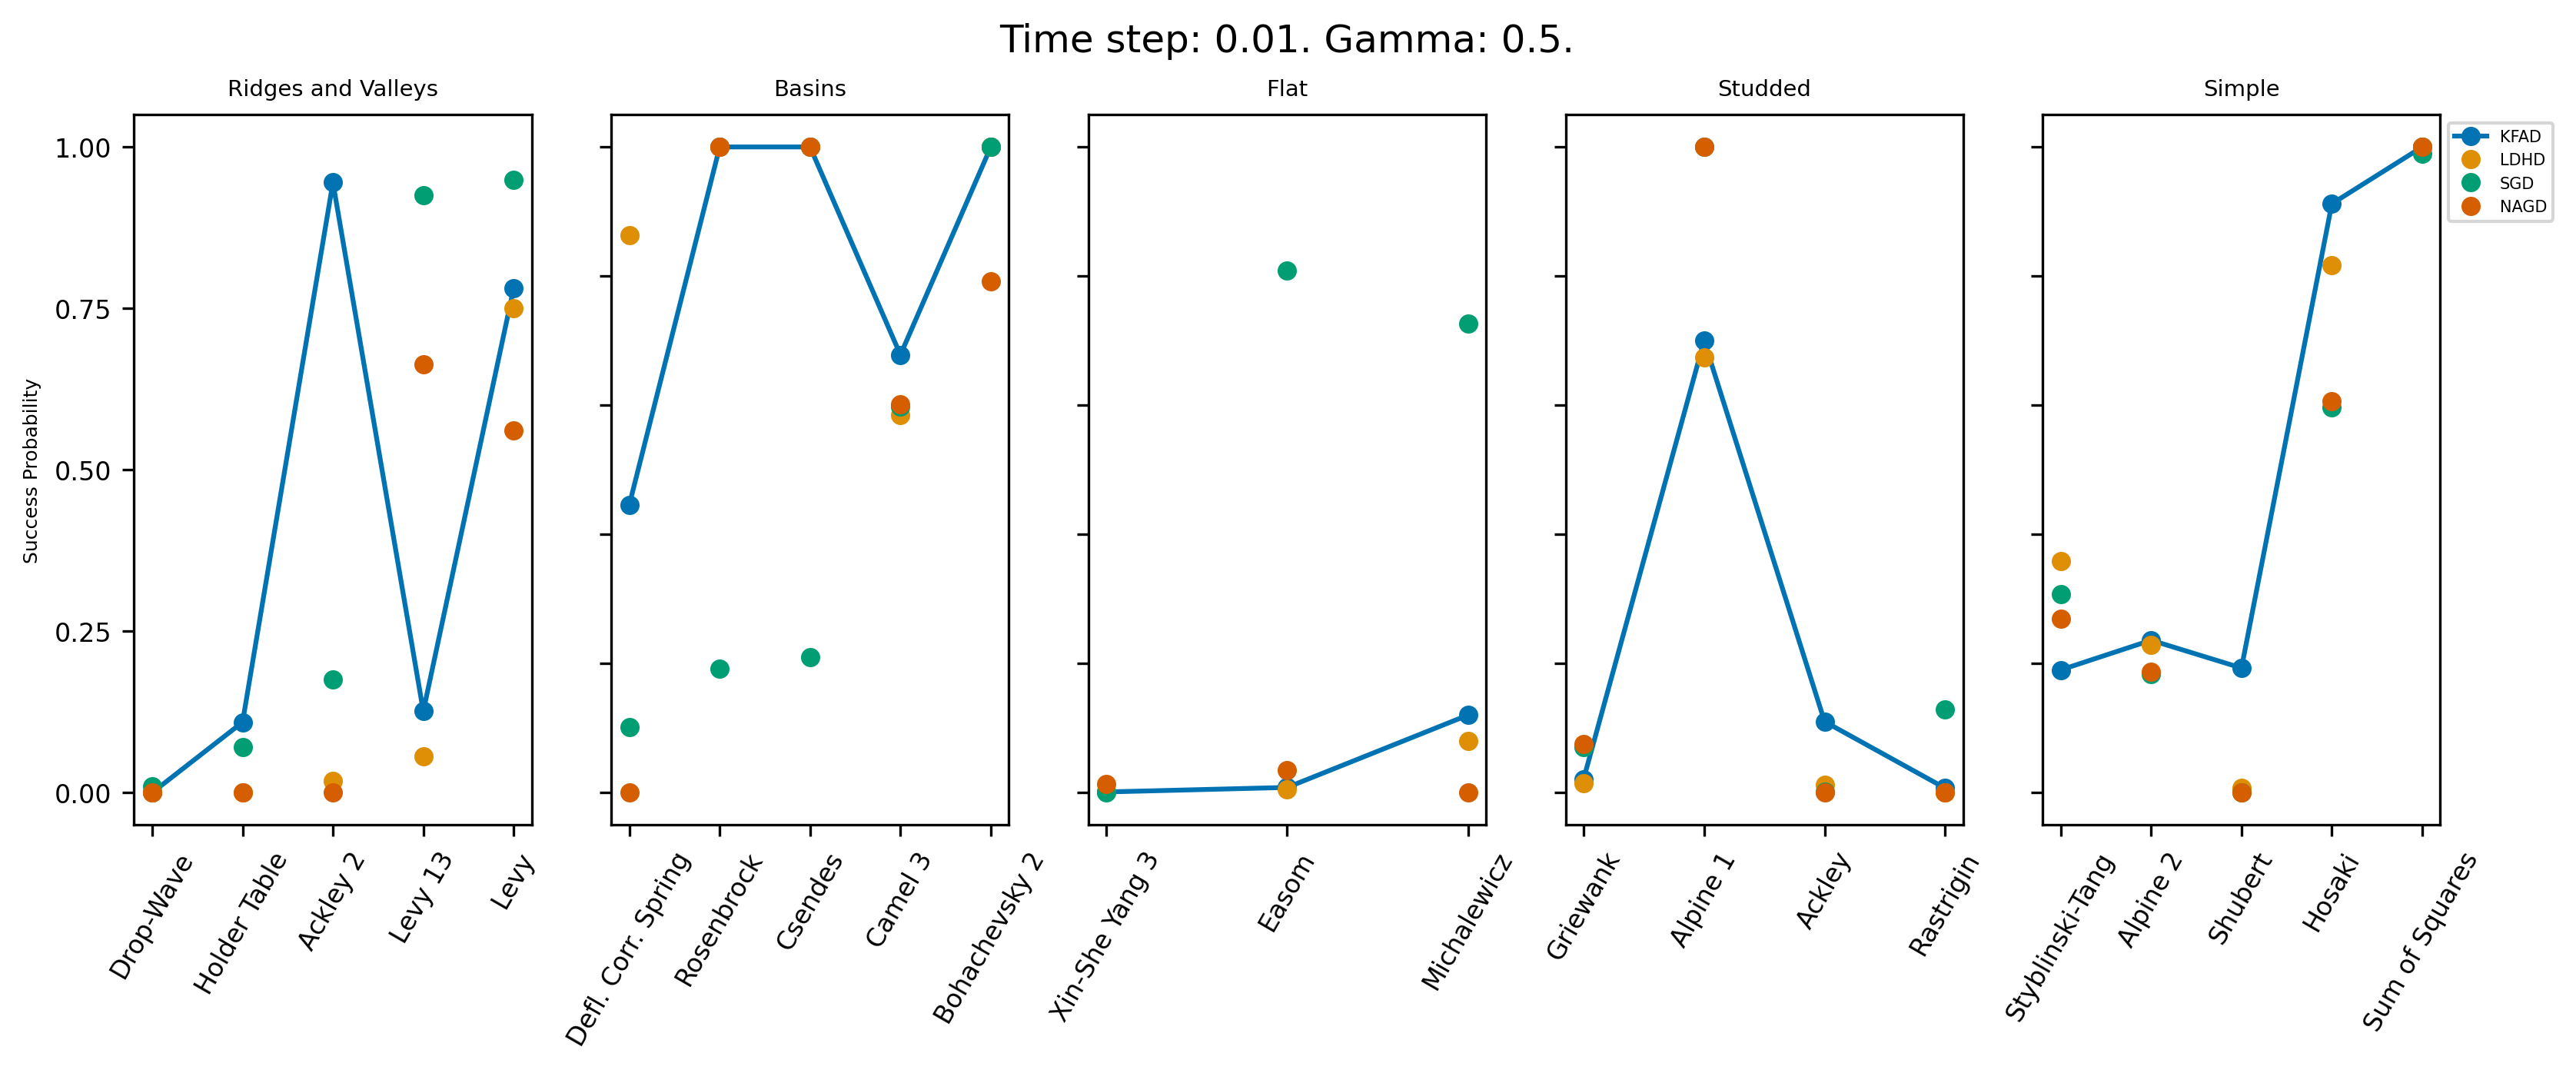

In [8]:
NUM_SHOTS = 1000

radius = 0.1
steps = 256
adb_steps = 64


DATA_DIR_2D = "/Users/analiacabello/Desktop/Y5/DISS/2D_matlab_experiments"
sys.path.append(os.path.abspath('../../'))


# LOAD success prob data
data = {
    "SGD": {},
    "LDHD": {},
    "KFAD": {},
    "NAGD": {},
    "QHD": {}
}

prob_data = {
    "SGD": [],
    "LDHD": [],
    "KFAD": [],
    "NAGD": [],
    "QHD": []
}


NUM_SHOTS = 1000

radius = 0.1
steps = 256
adb_steps = 64

for d in dirs:
    if not isdir(join(DATA_DIR_2D, d)):
        print(f"The data path for function {d} is not found.")
    else:
        print(d)
        scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_SGD.mat"), mdict=data["SGD"])

        scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_LDHD.mat"), mdict=data["LDHD"])
        
        scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_KFAD.mat"), mdict=data["KFAD"])
        
        scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_NAGD.mat"), mdict=data["NAGD"])

        #adb_filename = f"{d}_QAA128_T10.mat"
        #adb_f = h5py.File(join(DATA_DIR_2D, d, adb_filename), 'r')
        #for k, v in adb_f.items():
        #    data["QAA"][k] = np.array(adb_f.get(k))

        #qhd_wfn_dir = f"{d}_QHD256_WFN"
        #data["QHD"]["wfn"] = np.load(os.path.join(DATA_DIR_2D, d, qhd_wfn_dir, "psi_100e-01.npy"))


####### # SGD
        counter = 0
        for i in range(NUM_SHOTS):
            last_idx = data["SGD"]["ngd_last_frame"][i] - 1
            point = data["SGD"]["ngd_positions"][i, last_idx, :][0]

            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1

        prob_data["SGD"].append(counter / NUM_SHOTS)

####### # LDHD
        counter = 0
        for i in range(NUM_SHOTS):
            point = data["LDHD"]["ldhd_positions"][i][-1]

            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1

        prob_data["LDHD"].append(counter / NUM_SHOTS)
        
####### # KFAD
        counter = 0
        for i in range(NUM_SHOTS):
            point = data["KFAD"]["kfad_positions"][i][-1]

            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1

        prob_data["KFAD"].append(counter / NUM_SHOTS)
        
####### # NAGD
        counter = 0
        for i in range(NUM_SHOTS):
            point = data["NAGD"]["nesterov_positions"][i][-1]

            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1

        prob_data["NAGD"].append(counter / NUM_SHOTS)

####### # QUANTUM ADIABATIC
#        x_adb_data = data["QAA"]["snapshot_times"][0]
#        adb_wfn = data["QAA"]["wfn"].view(np.complex128)
#        adb_num_frames = len(x_adb_data)
#        adb_nbhd_prob = np.empty(adb_num_frames)
#        adb_nbhd_idcs = grid_points_within_radius(global_min_locs[d], radius, adb_steps)
#        adb_frame = adb_wfn[:,-1]
#        adb_nbhd_amps = adb_frame[adb_nbhd_idcs]
#        adb_prob = np.sum((adb_nbhd_amps * np.conj(adb_nbhd_amps)).real)
#        prob_data["QAA"].append(adb_prob)

####### # QUANTUM HAMILTONIAN DESCENT
#        nbhd_idcs = grid_points_within_radius(global_min_locs[d], radius, steps)
 #       nbhd_locs = np.zeros((steps * steps,1))
 #       nbhd_locs[nbhd_idcs] = 1
 #       nbhd_locs = np.reshape(nbhd_locs, (steps,steps), order='F')

 #       psi = data["QHD"]["wfn"]
 #       qhd_prob = (nbhd_locs * ((psi * psi.conj()).real)).sum()
  #      prob_data["QHD"].append(qhd_prob)


# STORE data in pd dataframe
pd.set_option("display.precision", 3)

prob_df = pd.DataFrame({
    "SGD": prob_data["SGD"],
    "LDHD": prob_data["LDHD"],
    "KFAD": prob_data["KFAD"],
    "NAGD": prob_data["NAGD"]},
    index=dirs)


# GENERATE SUCCESS PROBABILITY TABLE from dataframe
def highlight_top_k(s, k=1, cmap=[("black", "[HTML]{EEEEEE}")]):
    unsortedvals = [v for v in s.values if not np.isnan(v)]
    topk = sorted(unsortedvals, reverse=True)[:k]
    topk_vals = sorted(list(set(topk)), reverse=True)

    props = s.shape[0] * ['']

    for top_idx in range(len(topk_vals)):
        val = topk_vals[top_idx]
        text_color = cmap[top_idx][0]
        bg_color = cmap[top_idx][1]
        for c_idx in range(len(s.values)):
            if np.allclose(s.values[c_idx], val, atol=1e-3):
                props[c_idx] = f'color:{{{text_color}}}; cellcolor:{bg_color}; bfseries:'
    return np.array(props, dtype=object)


def relabel_data(val):
    if val > 0.999 and val < 1:
        return "$>$0.999"
    return format(round(val, 3), ".3f")


def relabel_index_headers(val):
    return val


colored_table = prob_df.style.apply(highlight_top_k, axis=1).export()

# Dump the table to the console
#print(prob_df.rename(lambda idx: idx.replace('_',' ')).style.format(relabel_data).use(colored_table).to_latex(column_format="l|cccc"))
# print(prob_df.rename(lambda idx: idx.replace('_',' ')).to_markdown(tablefmt="grid"))


# Sorted by QHD success prob in each category
features = {
    "Ridges and Valleys": [
        "dropwave",
        "holder",
        "ackley2",
        "levy13",
        "levy",
        
    ],
    "Basins": [
        "defl_corr_spring",
        "rosenbrock",
        "csendes",
        "camel3",
        "bohachevsky2",
    ],
    "Flat": [
        "xinsheyang3",
        "easom",
        "michalewicz",
    ],
    "Studded": [
        "griewank",
        "alpine1",
        "ackley",
        "rastrigin",
    ],
    "Simple": [
        "styblinski_tang",
        "alpine2",
        "shubert",
        "hosaki",
        "sumofsquares",    
    ]
}

fname_to_label = {
    "dropwave": "Drop-Wave",
    "levy": "Levy",
    "levy13": "Levy 13",
    "holder": "Holder Table",
    "ackley2": "Ackley 2",
    "bohachevsky2": "Bohachevsky 2",
    "rosenbrock": "Rosenbrock",
    "camel3": "Camel 3",
    "csendes": "Csendes",
    "defl_corr_spring": "Defl. Corr. Spring",
    "michalewicz": "Michalewicz",
    "easom": "Easom",
    "xinsheyang3": "Xin-She Yang 3",
    "alpine1": "Alpine 1",
    "griewank": "Griewank",
    "ackley": "Ackley",
    "rastrigin": "Rastrigin",
    "alpine2": "Alpine 2",
    "hosaki": "Hosaki",
    "shubert": "Shubert",
    "styblinski_tang": "Styblinski-Tang",
    "sumofsquares": "Sum of Squares"
}


# PLOT by methods across instances separated by instance type
which_to_plot = [ "KFAD", "LDHD", "SGD","NAGD"]

MARKER_SIZE = 5

CATTITLE_SIZE = 7
YLABEL_SIZE = 6
YTICKLABEL_SIZE = 8
XTICKLABEL_SIZE = 8
LEGEND_SIZE = 5

cmap = sns.color_palette("colorblind")
# cmap = cmap[:5] + cmap[8:]
cmap = cmap[:5] + cmap[6:]

f, ax = plt.subplots(1, 5, figsize=(150/15, 4), dpi=300)
f.suptitle("Time step: 0.01. Gamma: 0.5.")
# figsize=(150/25.4, 2) originally
plt.subplots_adjust(left=0.0, right=1)

for method_idx in range(len(which_to_plot)):
    method = which_to_plot[method_idx]
    ax[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax[0].set_ylabel("Success Probability", size=YLABEL_SIZE)
    for category_idx in range(len(list(features.keys()))):
        category = list(features.keys())[category_idx]
        X = list(range(len(features[category])))
        Y = [prob_df[method][dirs.index(fn)] for fn in features[category]]

        # Only connect QHD markers
        linestyle = ""
        if method == "KFAD":
            linestyle = "-"

        ax[category_idx].plot(X, Y,
            color=cmap[method_idx],
            marker="o",
            markersize=MARKER_SIZE,
            linestyle=linestyle,
            label=method
        )

        if category_idx > 0:
            ax[category_idx].set_yticklabels([])

        ax[category_idx].set_title(category, fontsize=CATTITLE_SIZE)
        ax[category_idx].set_ylim([-0.05,1.05])
        ax[category_idx].set_xticks(list(range(len(X))))
        xlabels = [fname_to_label[fn] for fn in features[category]]
        ax[category_idx].set_xticklabels(xlabels, rotation=60,)
        ax[category_idx].tick_params(axis='x', which='major', labelsize=XTICKLABEL_SIZE)


# plt.suptitle("Success Probability Across Instance Categories")
ax[0].tick_params(axis='y', which='major', labelsize=YTICKLABEL_SIZE)
plt.legend(bbox_to_anchor=(1, 1), prop={'size': LEGEND_SIZE})

plt.savefig("./figures/SuccessProb2D.png", bbox_inches='tight', dpi=300)
#plt.savefig("./figures/SuccessProb2D.svg", bbox_inches='tight')
plt.show()

ackley
ackley2
alpine1
alpine2
bohachevsky2
camel3
csendes
defl_corr_spring
dropwave
easom
griewank
holder
hosaki
levy
levy13
michalewicz
rastrigin
rosenbrock
shubert
styblinski_tang
sumofsquares
xinsheyang3


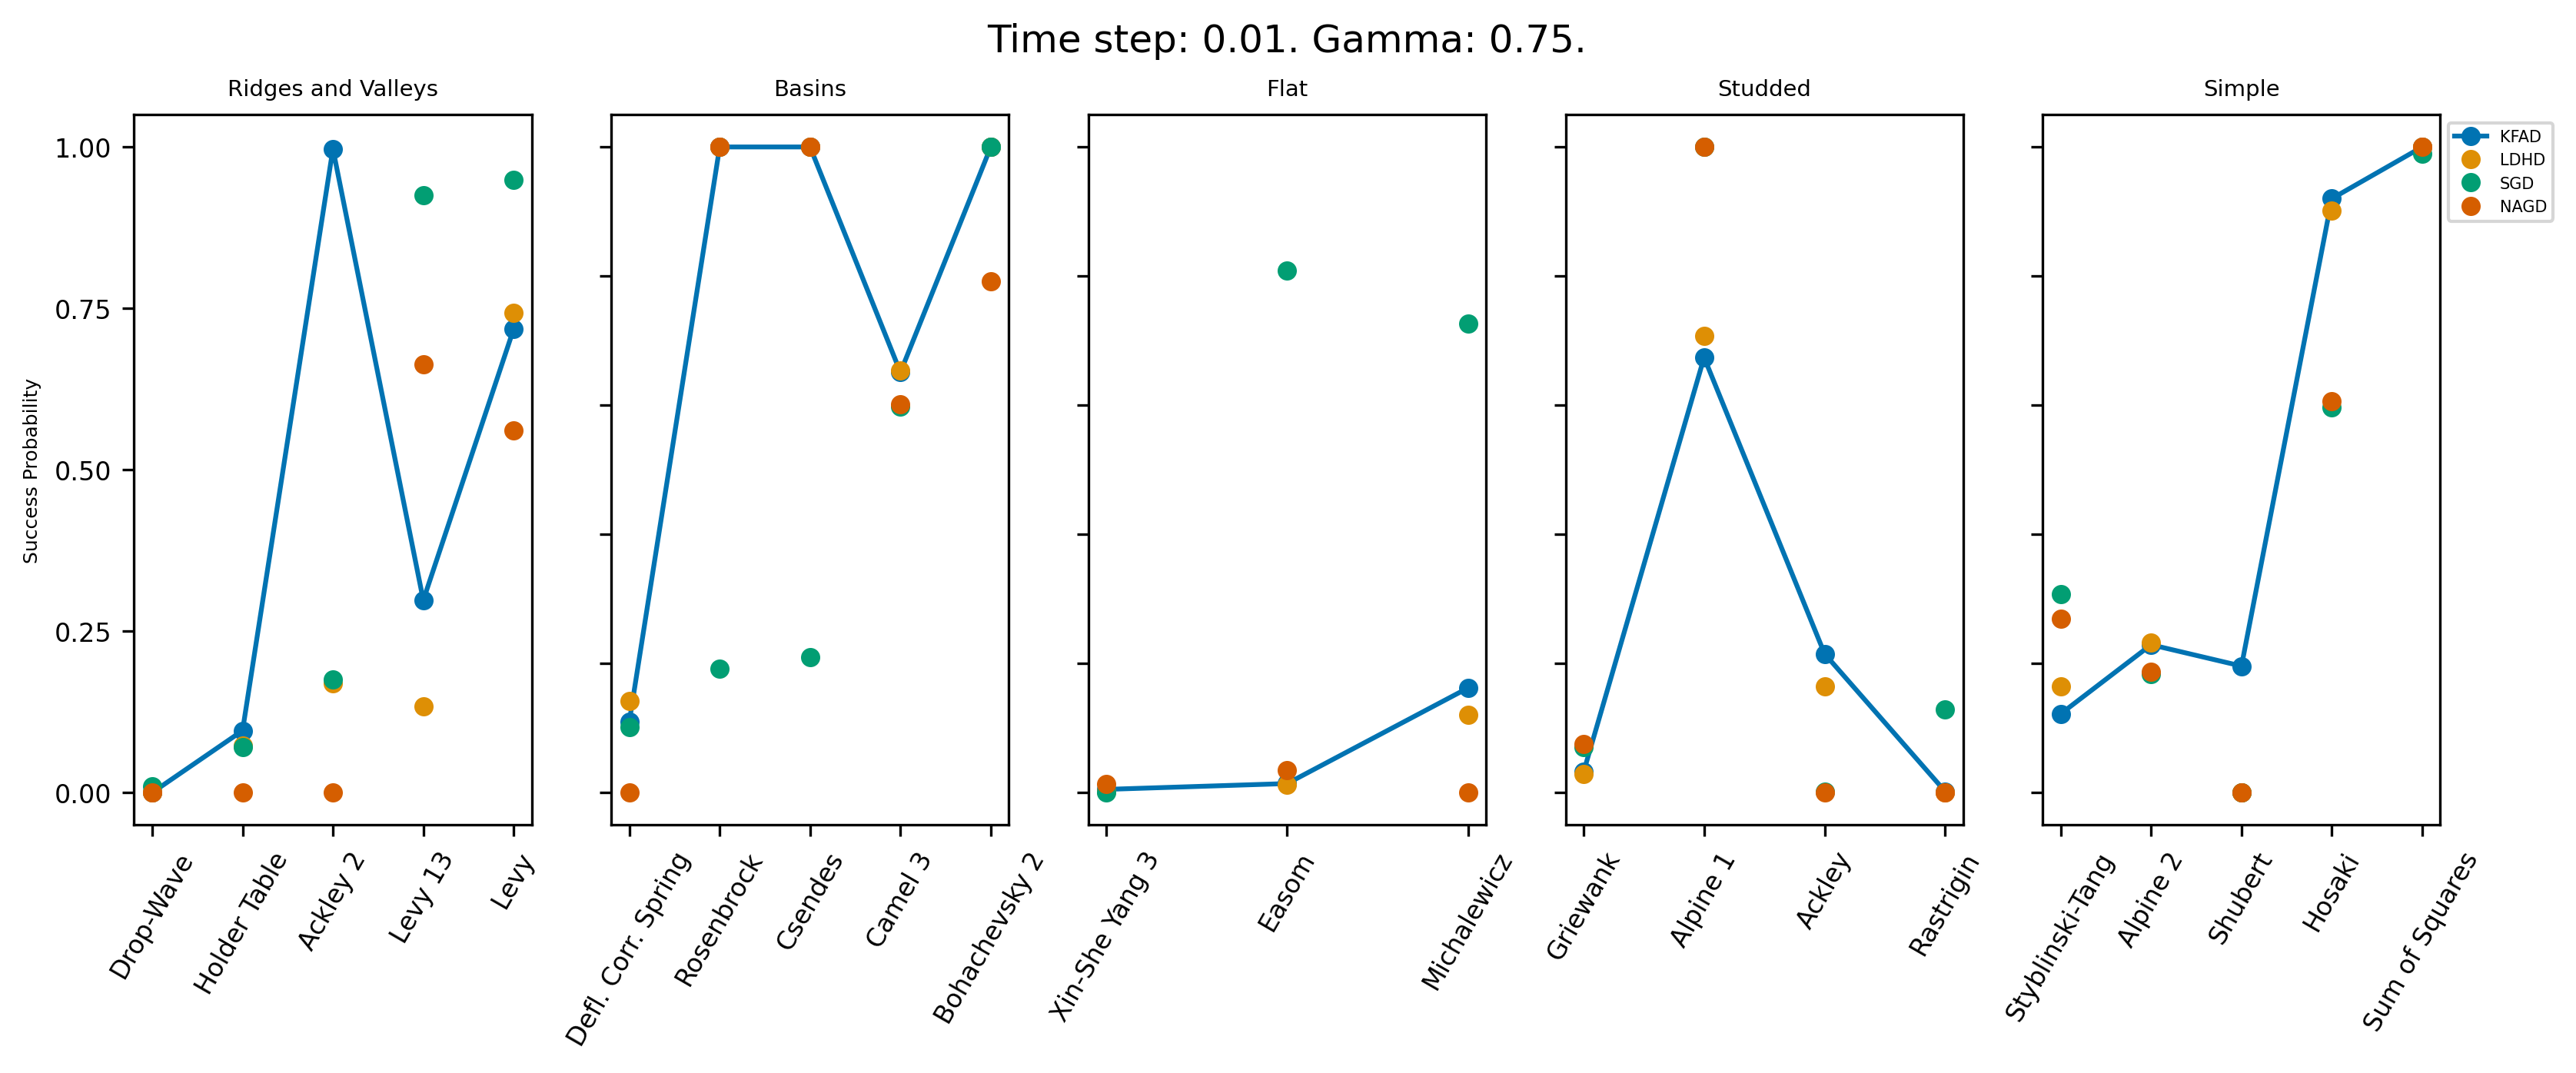

In [5]:
NUM_SHOTS = 1000

radius = 0.1
steps = 256
adb_steps = 64


DATA_DIR_2D = "/Users/analiacabello/Desktop/Y5/DISS/2D_matlab_experiments"
sys.path.append(os.path.abspath('../../'))


# LOAD success prob data
data = {
    "SGD": {},
    "LDHD": {},
    "KFAD": {},
    "NAGD": {},
    "QHD": {}
}

prob_data = {
    "SGD": [],
    "LDHD": [],
    "KFAD": [],
    "NAGD": [],
    "QHD": []
}


NUM_SHOTS = 1000

radius = 0.1
steps = 256
adb_steps = 64

for d in dirs:
    if not isdir(join(DATA_DIR_2D, d)):
        print(f"The data path for function {d} is not found.")
    else:
        print(d)
        scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_SGD.mat"), mdict=data["SGD"])

        scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_LDHD.mat"), mdict=data["LDHD"])
        
        scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_KFAD.mat"), mdict=data["KFAD"])
        
        scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_NAGD.mat"), mdict=data["NAGD"])

        #adb_filename = f"{d}_QAA128_T10.mat"
        #adb_f = h5py.File(join(DATA_DIR_2D, d, adb_filename), 'r')
        #for k, v in adb_f.items():
        #    data["QAA"][k] = np.array(adb_f.get(k))

        #qhd_wfn_dir = f"{d}_QHD256_WFN"
        #data["QHD"]["wfn"] = np.load(os.path.join(DATA_DIR_2D, d, qhd_wfn_dir, "psi_100e-01.npy"))


####### # SGD
        counter = 0
        for i in range(NUM_SHOTS):
            last_idx = data["SGD"]["ngd_last_frame"][i] - 1
            point = data["SGD"]["ngd_positions"][i, last_idx, :][0]

            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1

        prob_data["SGD"].append(counter / NUM_SHOTS)

####### # LDHD
        counter = 0
        for i in range(NUM_SHOTS):
            point = data["LDHD"]["ldhd_positions"][i][-1]

            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1

        prob_data["LDHD"].append(counter / NUM_SHOTS)
        
####### # KFAD
        counter = 0
        for i in range(NUM_SHOTS):
            point = data["KFAD"]["kfad_positions"][i][-1]

            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1

        prob_data["KFAD"].append(counter / NUM_SHOTS)
        
####### # NAGD
        counter = 0
        for i in range(NUM_SHOTS):
            point = data["NAGD"]["nesterov_positions"][i][-1]

            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1

        prob_data["NAGD"].append(counter / NUM_SHOTS)

####### # QUANTUM ADIABATIC
#        x_adb_data = data["QAA"]["snapshot_times"][0]
#        adb_wfn = data["QAA"]["wfn"].view(np.complex128)
#        adb_num_frames = len(x_adb_data)
#        adb_nbhd_prob = np.empty(adb_num_frames)
#        adb_nbhd_idcs = grid_points_within_radius(global_min_locs[d], radius, adb_steps)
#        adb_frame = adb_wfn[:,-1]
#        adb_nbhd_amps = adb_frame[adb_nbhd_idcs]
#        adb_prob = np.sum((adb_nbhd_amps * np.conj(adb_nbhd_amps)).real)
#        prob_data["QAA"].append(adb_prob)

####### # QUANTUM HAMILTONIAN DESCENT
#        nbhd_idcs = grid_points_within_radius(global_min_locs[d], radius, steps)
 #       nbhd_locs = np.zeros((steps * steps,1))
 #       nbhd_locs[nbhd_idcs] = 1
 #       nbhd_locs = np.reshape(nbhd_locs, (steps,steps), order='F')

 #       psi = data["QHD"]["wfn"]
 #       qhd_prob = (nbhd_locs * ((psi * psi.conj()).real)).sum()
  #      prob_data["QHD"].append(qhd_prob)


# STORE data in pd dataframe
pd.set_option("display.precision", 3)

prob_df = pd.DataFrame({
    "SGD": prob_data["SGD"],
    "LDHD": prob_data["LDHD"],
    "KFAD": prob_data["KFAD"],
    "NAGD": prob_data["NAGD"]},
    index=dirs)


# GENERATE SUCCESS PROBABILITY TABLE from dataframe
def highlight_top_k(s, k=1, cmap=[("black", "[HTML]{EEEEEE}")]):
    unsortedvals = [v for v in s.values if not np.isnan(v)]
    topk = sorted(unsortedvals, reverse=True)[:k]
    topk_vals = sorted(list(set(topk)), reverse=True)

    props = s.shape[0] * ['']

    for top_idx in range(len(topk_vals)):
        val = topk_vals[top_idx]
        text_color = cmap[top_idx][0]
        bg_color = cmap[top_idx][1]
        for c_idx in range(len(s.values)):
            if np.allclose(s.values[c_idx], val, atol=1e-3):
                props[c_idx] = f'color:{{{text_color}}}; cellcolor:{bg_color}; bfseries:'
    return np.array(props, dtype=object)


def relabel_data(val):
    if val > 0.999 and val < 1:
        return "$>$0.999"
    return format(round(val, 3), ".3f")


def relabel_index_headers(val):
    return val


colored_table = prob_df.style.apply(highlight_top_k, axis=1).export()

# Dump the table to the console
#print(prob_df.rename(lambda idx: idx.replace('_',' ')).style.format(relabel_data).use(colored_table).to_latex(column_format="l|cccc"))
# print(prob_df.rename(lambda idx: idx.replace('_',' ')).to_markdown(tablefmt="grid"))


# Sorted by QHD success prob in each category
features = {
    "Ridges and Valleys": [
        "dropwave",
        "holder",
        "ackley2",
        "levy13",
        "levy",
        
    ],
    "Basins": [
        "defl_corr_spring",
        "rosenbrock",
        "csendes",
        "camel3",
        "bohachevsky2",
    ],
    "Flat": [
        "xinsheyang3",
        "easom",
        "michalewicz",
    ],
    "Studded": [
        "griewank",
        "alpine1",
        "ackley",
        "rastrigin",
    ],
    "Simple": [
        "styblinski_tang",
        "alpine2",
        "shubert",
        "hosaki",
        "sumofsquares",    
    ]
}

fname_to_label = {
    "dropwave": "Drop-Wave",
    "levy": "Levy",
    "levy13": "Levy 13",
    "holder": "Holder Table",
    "ackley2": "Ackley 2",
    "bohachevsky2": "Bohachevsky 2",
    "rosenbrock": "Rosenbrock",
    "camel3": "Camel 3",
    "csendes": "Csendes",
    "defl_corr_spring": "Defl. Corr. Spring",
    "michalewicz": "Michalewicz",
    "easom": "Easom",
    "xinsheyang3": "Xin-She Yang 3",
    "alpine1": "Alpine 1",
    "griewank": "Griewank",
    "ackley": "Ackley",
    "rastrigin": "Rastrigin",
    "alpine2": "Alpine 2",
    "hosaki": "Hosaki",
    "shubert": "Shubert",
    "styblinski_tang": "Styblinski-Tang",
    "sumofsquares": "Sum of Squares"
}


# PLOT by methods across instances separated by instance type
which_to_plot = [ "KFAD", "LDHD", "SGD","NAGD"]

MARKER_SIZE = 5

CATTITLE_SIZE = 7
YLABEL_SIZE = 6
YTICKLABEL_SIZE = 8
XTICKLABEL_SIZE = 8
LEGEND_SIZE = 5

cmap = sns.color_palette("colorblind")
# cmap = cmap[:5] + cmap[8:]
cmap = cmap[:5] + cmap[6:]

f, ax = plt.subplots(1, 5, figsize=(150/15, 4), dpi=300)
f.suptitle("Time step: 0.01. Gamma: 0.75.")
# figsize=(150/25.4, 2) originally
plt.subplots_adjust(left=0.0, right=1)

for method_idx in range(len(which_to_plot)):
    method = which_to_plot[method_idx]
    ax[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax[0].set_ylabel("Success Probability", size=YLABEL_SIZE)
    for category_idx in range(len(list(features.keys()))):
        category = list(features.keys())[category_idx]
        X = list(range(len(features[category])))
        Y = [prob_df[method][dirs.index(fn)] for fn in features[category]]

        # Only connect QHD markers
        linestyle = ""
        if method == "KFAD":
            linestyle = "-"

        ax[category_idx].plot(X, Y,
            color=cmap[method_idx],
            marker="o",
            markersize=MARKER_SIZE,
            linestyle=linestyle,
            label=method
        )

        if category_idx > 0:
            ax[category_idx].set_yticklabels([])

        ax[category_idx].set_title(category, fontsize=CATTITLE_SIZE)
        ax[category_idx].set_ylim([-0.05,1.05])
        ax[category_idx].set_xticks(list(range(len(X))))
        xlabels = [fname_to_label[fn] for fn in features[category]]
        ax[category_idx].set_xticklabels(xlabels, rotation=60,)
        ax[category_idx].tick_params(axis='x', which='major', labelsize=XTICKLABEL_SIZE)


# plt.suptitle("Success Probability Across Instance Categories")
ax[0].tick_params(axis='y', which='major', labelsize=YTICKLABEL_SIZE)
plt.legend(bbox_to_anchor=(1, 1), prop={'size': LEGEND_SIZE})

plt.savefig("./figures/SuccessProb2D.png", bbox_inches='tight', dpi=300)
#plt.savefig("./figures/SuccessProb2D.svg", bbox_inches='tight')
plt.show()

ackley
ackley2
alpine1
alpine2
bohachevsky2
camel3
csendes
defl_corr_spring
dropwave
easom
griewank
holder
hosaki
levy
levy13
michalewicz
rastrigin
rosenbrock
shubert
styblinski_tang
sumofsquares
xinsheyang3


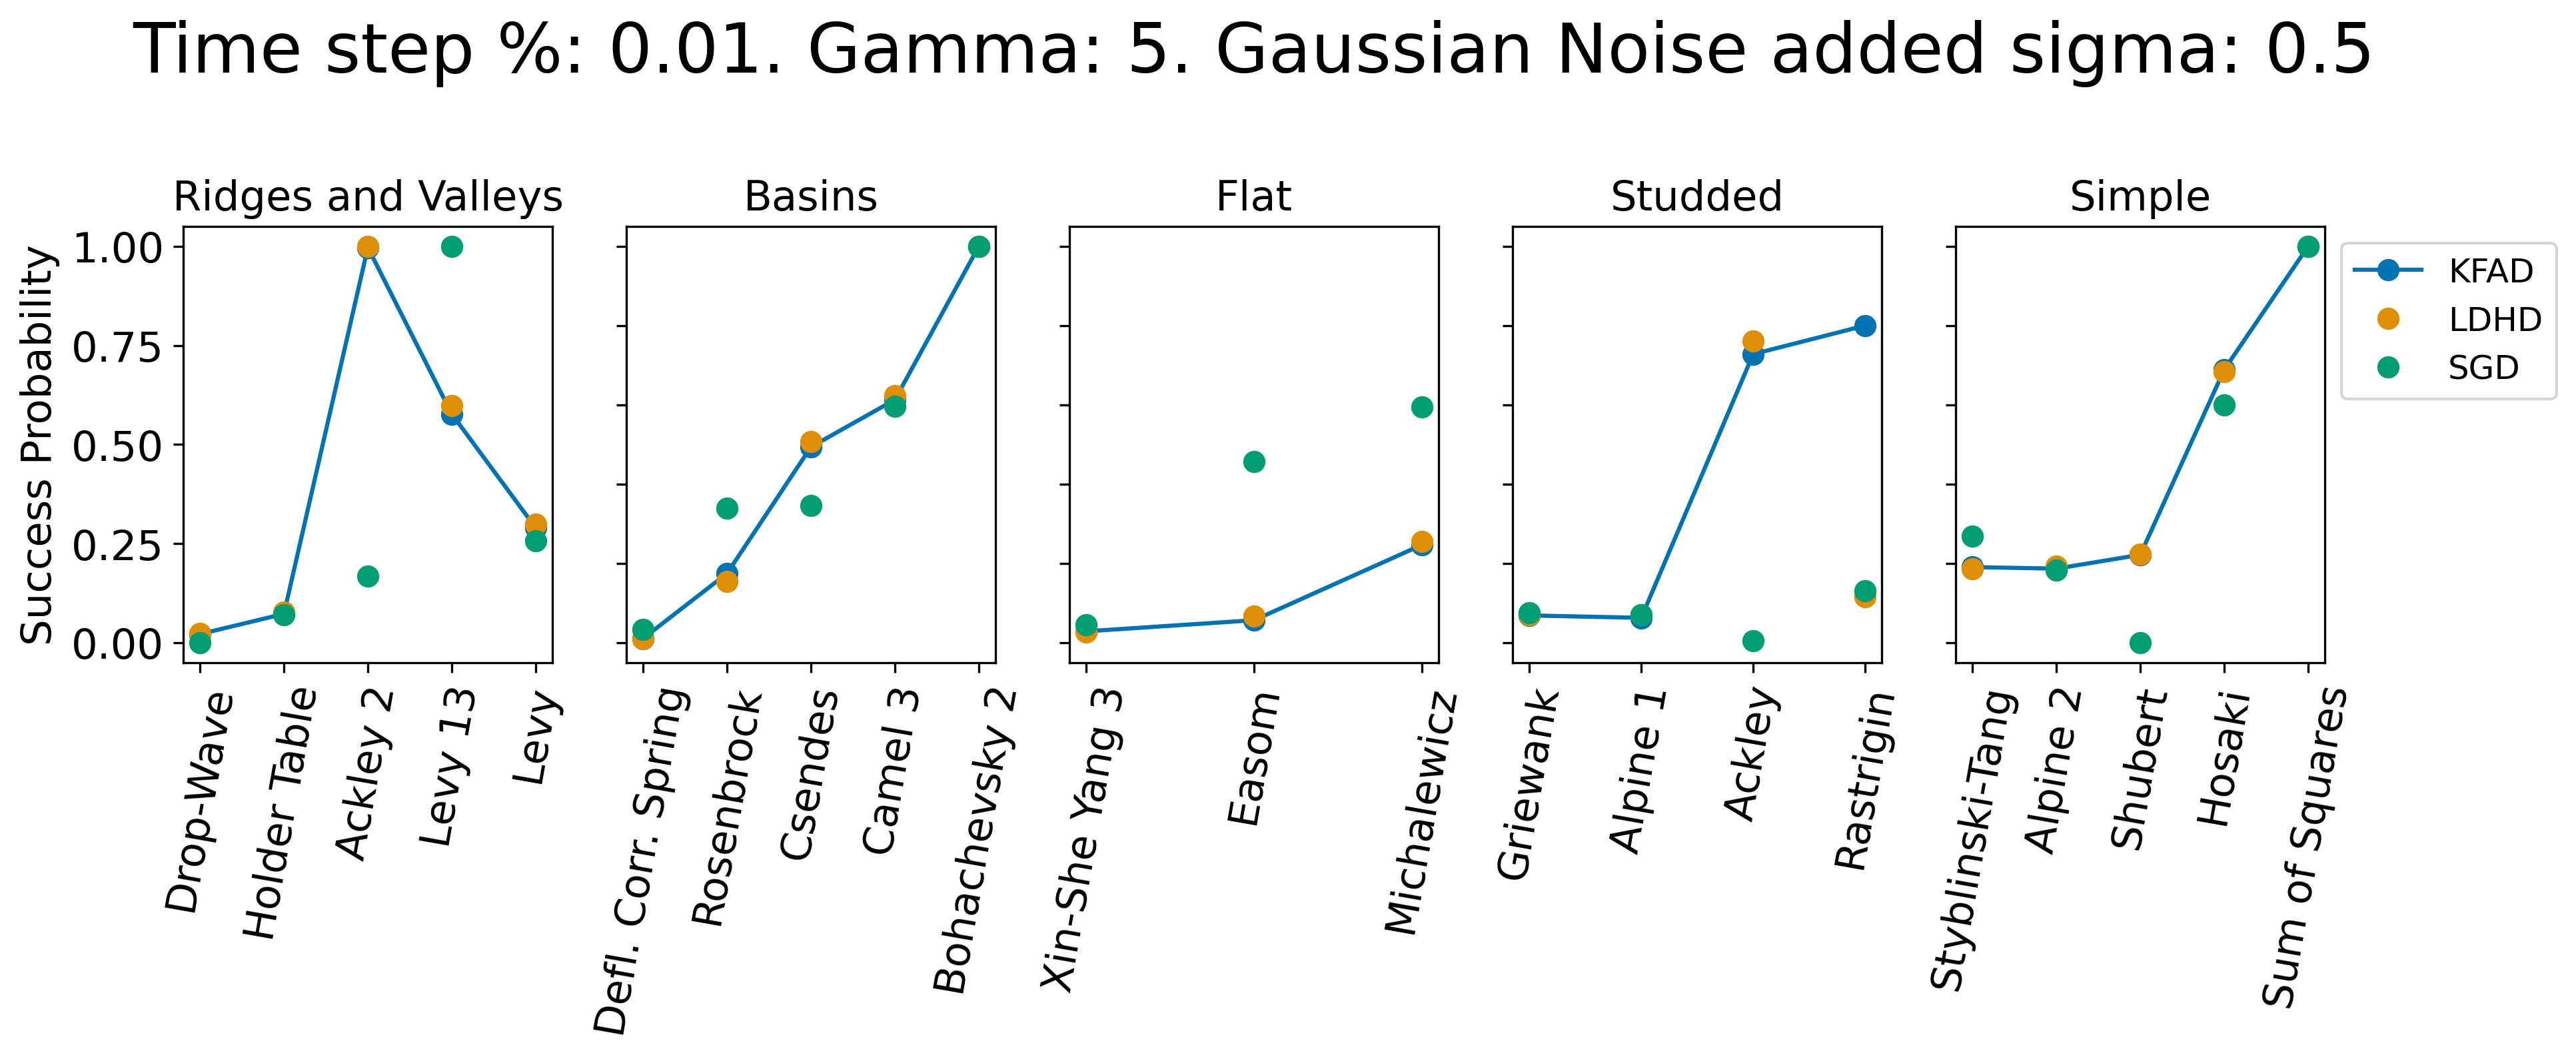

In [52]:
NUM_SHOTS = 1000

radius = 0.1
steps = 256
adb_steps = 64


DATA_DIR_2D = "/Users/analiacabello/Desktop/Y5/DISS/2D_matlab_experiments"
sys.path.append(os.path.abspath('../../'))


# LOAD success prob data
data = {
    "SGD": {},
    "LDHD": {},
    "KFAD": {},
}

prob_data = {
    "SGD": [],
    "LDHD": [],
    "KFAD": [],
}


NUM_SHOTS = 1000

radius = 0.1
steps = 256
adb_steps = 64

for d in dirs:
    if not isdir(join(DATA_DIR_2D, d)):
        print(f"The data path for function {d} is not found.")
    else:
        print(d)
        scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_SGD.mat"), mdict=data["SGD"])

        scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_LDHD.mat"), mdict=data["LDHD"])
        
        scipy.io.loadmat(join(DATA_DIR_2D, d, f"{d}_KFAD.mat"), mdict=data["KFAD"])
        

        #adb_filename = f"{d}_QAA128_T10.mat"
        #adb_f = h5py.File(join(DATA_DIR_2D, d, adb_filename), 'r')
        #for k, v in adb_f.items():
        #    data["QAA"][k] = np.array(adb_f.get(k))

        #qhd_wfn_dir = f"{d}_QHD256_WFN"
        #data["QHD"]["wfn"] = np.load(os.path.join(DATA_DIR_2D, d, qhd_wfn_dir, "psi_100e-01.npy"))


####### # SGD
        counter = 0
        for i in range(NUM_SHOTS):
            last_idx = data["SGD"]["ngd_last_frame"][i] - 1
            point = data["SGD"]["ngd_positions"][i, last_idx, :][0]

            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1

        prob_data["SGD"].append(counter / NUM_SHOTS)

####### # LDHD
        counter = 0
        for i in range(NUM_SHOTS):
            point = data["LDHD"]["ldhd_positions"][i][-1]

            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1

        prob_data["LDHD"].append(counter / NUM_SHOTS)
        
####### # KFAD
        counter = 0
        for i in range(NUM_SHOTS):
            point = data["KFAD"]["kfad_positions"][i][-1]

            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1

        prob_data["KFAD"].append(counter / NUM_SHOTS)
        

####### # QUANTUM ADIABATIC
#        x_adb_data = data["QAA"]["snapshot_times"][0]
#        adb_wfn = data["QAA"]["wfn"].view(np.complex128)
#        adb_num_frames = len(x_adb_data)
#        adb_nbhd_prob = np.empty(adb_num_frames)
#        adb_nbhd_idcs = grid_points_within_radius(global_min_locs[d], radius, adb_steps)
#        adb_frame = adb_wfn[:,-1]
#        adb_nbhd_amps = adb_frame[adb_nbhd_idcs]
#        adb_prob = np.sum((adb_nbhd_amps * np.conj(adb_nbhd_amps)).real)
#        prob_data["QAA"].append(adb_prob)

####### # QUANTUM HAMILTONIAN DESCENT
#        nbhd_idcs = grid_points_within_radius(global_min_locs[d], radius, steps)
 #       nbhd_locs = np.zeros((steps * steps,1))
 #       nbhd_locs[nbhd_idcs] = 1
 #       nbhd_locs = np.reshape(nbhd_locs, (steps,steps), order='F')

 #       psi = data["QHD"]["wfn"]
 #       qhd_prob = (nbhd_locs * ((psi * psi.conj()).real)).sum()
  #      prob_data["QHD"].append(qhd_prob)


# STORE data in pd dataframe
pd.set_option("display.precision", 3)

prob_df = pd.DataFrame({
    "SGD": prob_data["SGD"],
    "LDHD": prob_data["LDHD"],
    "KFAD": prob_data["KFAD"]},
    index=dirs)


# GENERATE SUCCESS PROBABILITY TABLE from dataframe
def highlight_top_k(s, k=1, cmap=[("black", "[HTML]{EEEEEE}")]):
    unsortedvals = [v for v in s.values if not np.isnan(v)]
    topk = sorted(unsortedvals, reverse=True)[:k]
    topk_vals = sorted(list(set(topk)), reverse=True)

    props = s.shape[0] * ['']

    for top_idx in range(len(topk_vals)):
        val = topk_vals[top_idx]
        text_color = cmap[top_idx][0]
        bg_color = cmap[top_idx][1]
        for c_idx in range(len(s.values)):
            if np.allclose(s.values[c_idx], val, atol=1e-3):
                props[c_idx] = f'color:{{{text_color}}}; cellcolor:{bg_color}; bfseries:'
    return np.array(props, dtype=object)


def relabel_data(val):
    if val > 0.999 and val < 1:
        return "$>$0.999"
    return format(round(val, 3), ".3f")


def relabel_index_headers(val):
    return val


colored_table = prob_df.style.apply(highlight_top_k, axis=1).export()

# Dump the table to the console
#print(prob_df.rename(lambda idx: idx.replace('_',' ')).style.format(relabel_data).use(colored_table).to_latex(column_format="l|cccc"))
# print(prob_df.rename(lambda idx: idx.replace('_',' ')).to_markdown(tablefmt="grid"))


# Sorted by QHD success prob in each category
features = {
    "Ridges and Valleys": [
        "dropwave",
        "holder",
        "ackley2",
        "levy13",
        "levy",
        
    ],
    "Basins": [
        "defl_corr_spring",
        "rosenbrock",
        "csendes",
        "camel3",
        "bohachevsky2",
    ],
    "Flat": [
        "xinsheyang3",
        "easom",
        "michalewicz",
    ],
    "Studded": [
        "griewank",
        "alpine1",
        "ackley",
        "rastrigin",
    ],
    "Simple": [
        "styblinski_tang",
        "alpine2",
        "shubert",
        "hosaki",
        "sumofsquares",    
    ]
}

fname_to_label = {
    "dropwave": "Drop-Wave",
    "levy": "Levy",
    "levy13": "Levy 13",
    "holder": "Holder Table",
    "ackley2": "Ackley 2",
    "bohachevsky2": "Bohachevsky 2",
    "rosenbrock": "Rosenbrock",
    "camel3": "Camel 3",
    "csendes": "Csendes",
    "defl_corr_spring": "Defl. Corr. Spring",
    "michalewicz": "Michalewicz",
    "easom": "Easom",
    "xinsheyang3": "Xin-She Yang 3",
    "alpine1": "Alpine 1",
    "griewank": "Griewank",
    "ackley": "Ackley",
    "rastrigin": "Rastrigin",
    "alpine2": "Alpine 2",
    "hosaki": "Hosaki",
    "shubert": "Shubert",
    "styblinski_tang": "Styblinski-Tang",
    "sumofsquares": "Sum of Squares"
}


# PLOT by methods across instances separated by instance type
which_to_plot = [ "KFAD", "LDHD", "SGD"]

MARKER_SIZE = 7

CATTITLE_SIZE = 15
YLABEL_SIZE = 15
YTICKLABEL_SIZE = 15
XTICKLABEL_SIZE = 15
LEGEND_SIZE = 12

cmap = sns.color_palette("colorblind")
# cmap = cmap[:5] + cmap[8:]
cmap = cmap[:5] + cmap[6:]

f, ax = plt.subplots(1, 5, figsize=(150/14, 3.7), dpi=300)
f.suptitle("Time step %: 0.01. Gamma: 5. Gaussian Noise added sigma: 0.5", fontsize=25)
# figsize=(150/25.4, 2) originally
plt.subplots_adjust(left=0.0, right=1)

for method_idx in range(len(which_to_plot)):
    method = which_to_plot[method_idx]
    ax[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax[0].set_ylabel("Success Probability", size=YLABEL_SIZE)
    for category_idx in range(len(list(features.keys()))):
        category = list(features.keys())[category_idx]
        X = list(range(len(features[category])))
        Y = [prob_df[method][dirs.index(fn)] for fn in features[category]]

        # Only connect QHD markers
        linestyle = ""
        if method == "KFAD":
            linestyle = "-"

        ax[category_idx].plot(X, Y,
            color=cmap[method_idx],
            marker="o",
            markersize=MARKER_SIZE,
            linestyle=linestyle,
            label=method
        )

        if category_idx > 0:
            ax[category_idx].set_yticklabels([])

        ax[category_idx].set_title(category, fontsize=CATTITLE_SIZE)
        ax[category_idx].set_ylim([-0.05,1.05])
        ax[category_idx].set_xticks(list(range(len(X))))
        xlabels = [fname_to_label[fn] for fn in features[category]]
        ax[category_idx].set_xticklabels(xlabels, rotation=80,)
        ax[category_idx].tick_params(axis='x', which='major', labelsize=XTICKLABEL_SIZE)


# plt.suptitle("Success Probability Across Instance Categories")
ax[0].tick_params(axis='y', which='major', labelsize=YTICKLABEL_SIZE)
plt.legend(bbox_to_anchor=(1, 1), prop={'size': LEGEND_SIZE})
plt.subplots_adjust(top=0.70)
plt.savefig("./figures/SuccessProb2D_sigma0.5_lr0.01_gamma5.png", bbox_inches='tight', dpi=300)
#plt.savefig("./figures/SuccessProb2D.svg", bbox_inches='tight')
plt.show()

## Individual function optimization

In [ ]:
# figures/2d_prob_plots/ackley2_sigma0.5_lr0.01_gamma0.2.png


In [20]:
print(data["KFAD"]["kfad_positions"][0,0,:])

[0.86100154 0.9558275 ]


In [44]:
print(data["KFAD"]["kfad_positions"][-1,:,:])

[[0.78782575 0.37265662]
 [0.79422145 0.37797337]
 [0.80056196 0.38323638]
 ...
 [1.         0.85380148]
 [1.         0.853807  ]
 [1.         0.85381253]]


In [45]:
print(data["KFAD"]["kfad_positions"][:,-1,:])

[[1.         1.        ]
 [0.76507177 1.        ]
 [1.         0.69825276]
 ...
 [1.         0.32327065]
 [0.92788197 1.        ]
 [1.         0.85381253]]


In [9]:
print(data["KFAD"]["kfad_positions"].shape)

(1000, 1000, 2)


In [12]:
print(data["SGD"]["ngd_positions"].shape)

(1000, 1000, 2)


In [13]:
print(data["SGD"]["ngd_positions"][:,-1,:])

[[0.75763214 0.9916746 ]
 [0.10896845 0.96667699]
 [0.63165395 0.01979031]
 ...
 [0.96772933 0.05681451]
 [0.42007067 0.98510673]
 [0.99534673 0.32152389]]
